In [1]:
import keras
DATASET_FOLDER = "../datasets/"
keras.__version__

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

'2.3.1'

Data preprocessing

In [2]:
import numpy as np
import pickle
def getData(datasetName):
    with open(datasetName,'rb') as file_in:
#         features, labels, setups, cameras, performers, replications = pickle.load(file_in)
        train_set, val_set, test_set = pickle.load(file_in)
    
    #### stats ################################
    nOfZeros = np.count_nonzero(train_set[0]==0)
    nOfZeros += np.count_nonzero(val_set[0]==0)
    nOfZeros += np.count_nonzero(test_set[0]==0)
    print("number of zeros(before padding): {}".format(nOfZeros))
    print("Train dataset shape: ", train_set[0].shape)
    print("Validation dataset shape: ", val_set[0].shape)
    print("Test dataset shape: ", test_set[0].shape)
    return train_set, val_set, test_set

In [3]:
from sklearn.preprocessing import LabelBinarizer
def one_hot_encoding(labels):
    encoder = LabelBinarizer()
    label_strings = [str(i) for i in labels]
    oneHotLabels = encoder.fit_transform(label_strings)
    print('classes order:', encoder.classes_) 
    return oneHotLabels
    
from sklearn.model_selection import StratifiedShuffleSplit
def balancedSplitting(features, labels, test_size = 0.5):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size)
    for train_idx, test_idx in sss.split(features, labels):
        X_train = features[train_idx]
        y_train = labels[train_idx]
        X_test = features[test_idx]
        y_test = labels[test_idx]
    return X_train, y_train, X_test, y_test
    
    
from keras.preprocessing.sequence import pad_sequences
def padding(features, max):
    maxLength = max([len(s) for s in  features])
    newFeatures = pad_sequences(features, maxlen=None, dtype='float32', padding='post', truncating='post', value=0.0)
    lenght = newFeatures.shape[0] * newFeatures.shape[1]*newFeatures.shape[2]*newFeatures.shape[3]
    numberOfZeros = np.count_nonzero(newFeatures==0)
    print("number of zeros(after padding): {} - {:.2f}%".format(numberOfZeros, numberOfZeros/(lenght)*100))
    print("Dataset shape: ", newFeatures.shape)
    return newFeatures

def paddingTrainValTest(X_train, X_val, X_test):
    maxLength = max([len(s) for s in np.concatenate((X_train, X_val, X_test), axis=0)])
    newXtrain = pad_sequences(X_train, maxlen=maxLength, dtype='float32', padding='post', truncating='post', value=0.0)
    newXval = pad_sequences(X_val, maxlen=maxLength, dtype='float32', padding='post', truncating='post', value=0.0)
    newXtest = pad_sequences(X_test, maxlen=maxLength, dtype='float32', padding='post', truncating='post', value=0.0)
    lenghtTrain = newXtrain.shape[0] * newXtrain.shape[1]*newXtrain.shape[2]*newXtrain.shape[3]
    lenghtVal = newXval.shape[0] * newXval.shape[1]*newXval.shape[2]*newXval.shape[3]
    lenghtTest = newXtest.shape[0] * newXtest.shape[1]*newXtest.shape[2]*newXtest.shape[3]
    numberOfZerosTrain = np.count_nonzero(newXtrain==0)
    numberOfZerosVal = np.count_nonzero(newXval==0)
    numberOfZerosTest = np.count_nonzero(newXtest==0)
    print("number of zeros train (after padding):\t\t{} - {:.2f}%".format(numberOfZerosTrain, numberOfZerosTrain/(lenghtTrain)*100))
    print("number of zeros validation (after padding):\t{} - {:.2f}%".format(numberOfZerosVal, numberOfZerosVal/(lenghtVal)*100))
    print("number of zeros test (after padding):\t\t{} - {:.2f}%".format(numberOfZerosTest, numberOfZerosTest/(lenghtTest)*100))
    print("Dataset train shape:\t\t", newXtrain.shape)
    print("Dataset validation shape:\t", newXval.shape)
    print("Dataset test shape:\t\t", newXtest.shape)
    return newXtrain, newXval, newXtest

In [4]:
import matplotlib.pyplot as plt 
def plotLabels(y_train,y_test):
    fig = plt.figure(figsize=(20,10))
    ax = plt.subplot("211")
    ax.set_title("Train", fontsize=16)
    ax.hist([str(i) for i in y_train], bins = 8) 

    ax = plt.subplot("212")
    ax.set_title("Test", fontsize=16)
    ax.hist([str(i) for i in y_train], bins = 8)

    plt.show()

In [5]:
def normaliseBeforePadding(X_train, X_val, X_test):
    trainAndVal = np.concatenate((X_train, X_val), axis=0)
    print("normalising train, val and test values BEFORE padding")
    trainMean = np.vstack(trainAndVal).mean() # the mean and std must be calculated only on the training data
    trainStd = np.vstack(trainAndVal).std()
    normalized_X_train = np.array([(x - trainMean)/trainStd for x in X_train])
    normalized_X_val = np.array([(x - trainMean)/trainStd for x in X_val])
    normalized_X_test = np.array([(x - trainMean)/trainStd for x in X_test])
    
    return normalized_X_train, normalized_X_val, normalized_X_test
    
    

In [6]:
def relativeToVideoCenter(X):
    print("Adapting the data to the center of each video")
    newX = X.copy()
    for i,frames in enumerate(X):
        # calculating the center of the frames points relative to the whole video
        videoMean = np.mean([np.mean(features,axis=0) for features in frames], axis = 0) 
        newX[i] = [frame-videoMean for frame in frames]

    return newX

# Posenet predicts:
# 1 - nose 
# 2 - leftEye 
# 3 - rightEye 
# 4 - leftEar 
# 5 - rightEar

# 6 - leftShoulder 
# 7 - rightShoulder
# 8 - leftElbow 
# 9 - rightElbow 
# 10 - leftWrist
# 11 - rightWrist 

# 12 - leftHip 
# 13 - rightHip 
# 14 - leftKnee 
# 15 - rightKnee 
# 16 - leftAnkle
# 17 - rightAnkle

def relativeToUpperMiddleBottomCentersOfFrame(X):
    print("Adapting the data to the TOP-MIDDLE-BOTTOM center of each frame")
    newX = X.copy()
    for i_video, video in enumerate(X):
        for i_frame, frame in enumerate(video):
            newX[i_video][i_frame][:5] = frame[:5] - np.mean(frame[:5], axis=0)
            newX[i_video][i_frame][5:11] = frame[5:11] - np.mean(frame[5:11], axis=0)
            newX[i_video][i_frame][11:17] = frame[11:17] - np.mean(frame[11:17], axis=0)
    return newX

def relativeToFrameCenter(X):
    print("Adapting the data to the center of each frame")
    newX = X.copy()
    for i_video, video in enumerate(X):
        for i_frame, frame in enumerate(video):
            frame_mean = np.mean(frame,axis=0)
            newX[i_video][i_frame] = frame - frame_mean

    return newX

In [7]:
def relativeToNextFrame(X):
    print("Adapting the data to the next frame")
    newX = []
    for frames in X:
        motions = []
        for i in range(len(frames)-1):
            motions.append(np.array(frames[i+1])-np.array(frames[i]))
        newX.append(motions)
    return np.array(newX)
  

# Loading data

In [9]:
SAVED_MODEL_FOLDER = "../savedModels/"
MODEL_NAME = "PoseNet-101"
# MODEL_NAME = "keypoint_rcnn_X_101_32x8d_FPN_3x"
PREPROCESS_FUNCTIONS = [relativeToUpperMiddleBottomCentersOfFrame]
NORMALIZE = True

## Determining save file name
saveFileName = MODEL_NAME
for fun in PREPROCESS_FUNCTIONS:
    saveFileName += "-{}".format(fun.__name__)

if NORMALIZE:
    saveFileName += "-norm"

saveFileName +=".h5"
saveFileName

'PoseNet-101-relativeToUpperMiddleBottomCentersOfFrame-norm.h5'

In [10]:
datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT-dataset.pickle"
train_set, val_set, test_set = getData(datasetName)

number of zeros(before padding): 0
Train dataset shape:  (5460,)
Validation dataset shape:  (1365,)
Test dataset shape:  (759,)


## Preprocessing

In [11]:
def preprocessData(train_set, val_set, test_set, normalize: bool, preprocess_functions=[] ):
    X_train, X_val, X_test = train_set[0], val_set[0], test_set[0]
    y_train = one_hot_encoding(train_set[1])
    y_val = one_hot_encoding(val_set[1])
    y_test = one_hot_encoding(test_set[1])

    for fun in preprocess_functions:
        X_train = fun(X_train)
        X_val = fun(X_val)
        X_test = fun(X_test)
    if normalize:
        X_train, X_val, X_test = normaliseBeforePadding(X_train, X_val, X_test)
    X_train, X_val, X_test = paddingTrainValTest(X_train, X_val, X_test)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [12]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocessData(train_set, val_set, test_set, NORMALIZE, PREPROCESS_FUNCTIONS)

classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the TOP-MIDDLE-BOTTOM center of each frame
Adapting the data to the TOP-MIDDLE-BOTTOM center of each frame
Adapting the data to the TOP-MIDDLE-BOTTOM center of each frame
normalising train, val and test values BEFORE padding
number of zeros train (after padding):		27738866 - 66.41%
number of zeros validation (after padding):	6942018 - 66.48%
number of zeros test (after padding):		3869268 - 66.64%
Dataset train shape:		 (5460, 225, 17, 2)
Dataset validation shape:	 (1365, 225, 17, 2)
Dataset test shape:		 (759, 225, 17, 2)


In [13]:
# X_to_try = np.arange(34*2).reshape(2,1,17,2)
# X_to_try

In [14]:
# relativeToUpperMiddleBottomCentersOfFrame(X_to_try)

In [15]:
## reshaping ###
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 17 * 2) 
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 17 * 2) 
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 17 * 2)

# Defining model

In [ ]:
from keras import models,layers
from keras.layers import LSTM
BATCH_SIZE = 32
length_in_frames = X_train.shape[1]
model = models.Sequential()
# model.add(layers.Dense(512, activation='relu', input_shape=(BATCH_SIZE, length_in_frames, 17 * 2)))
model.add(LSTM(64, input_shape=(length_in_frames, 17 * 2)))
model.add(layers.Dense(8, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                25344     
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 520       
Total params: 25,864
Trainable params: 25,864
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping

earlyStop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=100, verbose=1, mode='max', baseline=None, restore_best_weights=True)
callbacks_list = [earlyStop]

EPOCHS = 3000 #the earlystop will stop the training
history = model.fit(X_train, y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks_list,
#                     validation_split=0.2
                    validation_data=(X_val, y_val)
                   )

model.save(SAVED_MODEL_FOLDER+saveFileName)


Train on 5460 samples, validate on 1365 samples
Epoch 1/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 2.0803 - accuracy: 0.1141 - val_loss: 2.0791 - val_accuracy: 0.1260
Epoch 2/3000
5460/5460 [==============================] - 19s 3ms/step - loss: 2.0857 - accuracy: 0.1189 - val_loss: 2.0762 - val_accuracy: 0.1297
Epoch 3/3000
5460/5460 [==============================] - 19s 3ms/step - loss: 1.9786 - accuracy: 0.1769 - val_loss: 1.8783 - val_accuracy: 0.2337
Epoch 4/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 1.7559 - accuracy: 0.2542 - val_loss: 1.7450 - val_accuracy: 0.2527
Epoch 5/3000
5460/5460 [==============================] - 19s 3ms/step - loss: 1.6629 - accuracy: 0.2777 - val_loss: 1.6467 - val_accuracy: 0.2842
Epoch 6/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 1.6157 - accuracy: 0.2918 - val_loss: 1.8102 - val_accuracy: 0.2095
Epoch 7/3000
5460/5460 [==============================] - 19s 3ms/ste

5460/5460 [==============================] - 30s 6ms/step - loss: 0.1646 - accuracy: 0.9447 - val_loss: 0.4524 - val_accuracy: 0.8674
Epoch 110/3000
5460/5460 [==============================] - 29s 5ms/step - loss: 0.1669 - accuracy: 0.9462 - val_loss: 0.4861 - val_accuracy: 0.8586
Epoch 111/3000
5460/5460 [==============================] - 30s 6ms/step - loss: 0.1567 - accuracy: 0.9467 - val_loss: 0.4894 - val_accuracy: 0.8667
Epoch 112/3000
5460/5460 [==============================] - 29s 5ms/step - loss: 0.1472 - accuracy: 0.9507 - val_loss: 0.5057 - val_accuracy: 0.8667
Epoch 113/3000
5460/5460 [==============================] - 30s 6ms/step - loss: 0.1637 - accuracy: 0.9462 - val_loss: 0.4657 - val_accuracy: 0.8718
Epoch 114/3000
5460/5460 [==============================] - 29s 5ms/step - loss: 0.1644 - accuracy: 0.9441 - val_loss: 0.4555 - val_accuracy: 0.8703
Epoch 115/3000
5460/5460 [==============================] - 30s 6ms/step - loss: 0.1579 - accuracy: 0.9484 - val_loss: 0.

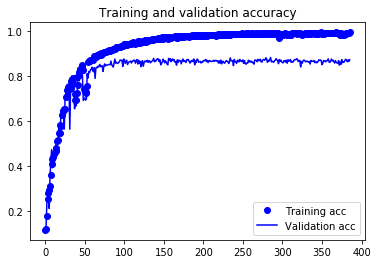

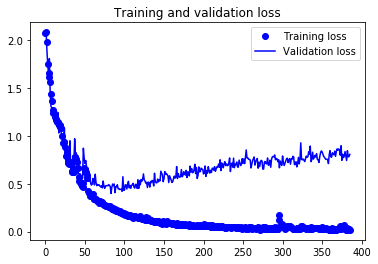

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [22]:
max(acc),max(val_acc),min(loss),min(val_loss)

(0.99597067, 0.8835164904594421, 0.018139998432276122, 0.39899959447401345)

In [23]:
np.argmax(val_acc)

285

## Display results

In [125]:
from sklearn.metrics import confusion_matrix, accuracy_score
# ACTION_LABEL_SET = 
    # A001  - A002 - A023          - A031               -  A049     - A007  - A008     - A009         
    # drink - eat -  hand waving   - point to something - use a fan - throw - sit down - standing up
def getValTestAccuracy(model,x_val,y_val,x_test,y_test, label_order = [1, 2, 31, 38, 49, 7, 8, 9]):
    y_val_pred = [label_order[i] for i in model.predict_classes(x_val)]
    y_val_true = [label_order[np.argmax(i)] for i in y_val]
    y_test_pred = [label_order[i] for i in model.predict_classes(x_test)]
    y_test_true = [label_order[np.argmax(i)] for i in y_test]
    val_acc = accuracy_score(y_pred=y_val_pred,y_true=y_val_true)
    test_acc = accuracy_score(y_pred=y_test_pred,y_true=y_test_true)
    return val_acc, test_acc
        
def plotValTestResult(model, x_val, y_val, x_test, y_test, label_order = [1, 2, 31, 38, 49, 7, 8, 9]):
    val_acc, test_acc = getValTestAccuracy(model,x_val,y_val,x_test,y_test)
    print("Val acc:",val_acc)
    print("Test acc:",test_acc)
    conf_mat_val= confusion_matrix(y_true=y_val_true, y_pred=y_val_pred, labels=label_order)            
    conf_mat_test = confusion_matrix(y_true=y_test_true, y_pred=y_test_pred, labels=label_order)
    plotConfusionMatrixes(conf_mat_val,conf_mat_test)

import seaborn as sn
def plotConfusionMatrixes(conf_mat_val, conf_mat_test, labelString = ["drink", "eat", "hand wave", "point-to", "fan", "throw", "sit-down", "stand-up"]):
    plt.figure(figsize = (15,7))
    ax1 = plt.subplot(1, 2, 1)
    ax1 = sn.heatmap(conf_mat_val, annot=True,xticklabels=labelString,yticklabels=labelString, fmt='g')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.title("VALIDATION SET", fontsize = 20) # title with fontsize 20
    plt.xlabel('Pred', fontsize = 15) # x-axis label with fontsize 15
    plt.ylabel('True', fontsize = 15) # y-axis label with fontsize 15
    
    ax2 = plt.subplot(1, 2, 2)
    ax2 = sn.heatmap(conf_mat_test, annot=True,xticklabels=labelString,yticklabels=labelString, fmt='g')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.title("TEST SET", fontsize = 20) # title with fontsize 20
    plt.xlabel('Pred', fontsize = 15) # x-axis label with fontsize 15

    plt.show()
    

## display model results

In [115]:
functionMap = {
    "relativeToFrameCenter": relativeToFrameCenter,
    "relativeToNextFrame": relativeToNextFrame,
    "relativeToVideoCenter": relativeToVideoCenter,
    "relativeToUpperMiddleBottomCentersOfFrame": relativeToUpperMiddleBottomCentersOfFrame}
def fromFileNameToParameters(fileName):
    parsedName = fileName.name[:-3].split("-")
    
    normalise = False
    if parsedName[-1]=="norm":
        normalise = True
        parsedName = parsedName[:-1]
        
    modelName = parsedName[0]
    parsedName = parsedName[1:]
    if modelName == "PoseNet":
        modelName += "-"+parsedName[0]
        parsedName = parsedName[1:]
    
    preprocess_functions = [functionMap[i] for i in parsedName]
    return modelName, preprocess_functions, normalise

classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the center of each video
Adapting the data to the center of each video
Adapting the data to the center of each video
number of zeros train (after padding):		27738866 - 66.41%
number of zeros validation (after padding):	6942018 - 66.48%
number of zeros test (after padding):		3869268 - 66.64%
Dataset train shape:		 (5460, 225, 17, 2)
Dataset validation shape:	 (1365, 225, 17, 2)
Dataset test shape:		 (759, 225, 17, 2)
PoseNet-101-relativeToVideoCenter.h5
Val acc: 0.8688644688644689
Test acc: 0.8511198945981555


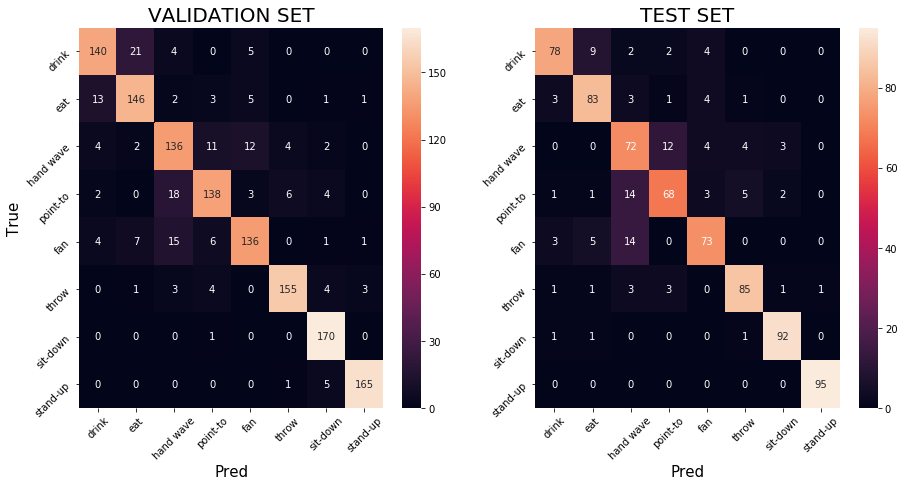

classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the center of each video
Adapting the data to the center of each video
Adapting the data to the center of each video
normalising train, val and test values BEFORE padding
number of zeros train (after padding):		27738866 - 66.41%
number of zeros validation (after padding):	6942018 - 66.48%
number of zeros test (after padding):		3869268 - 66.64%
Dataset train shape:		 (5460, 225, 17, 2)
Dataset validation shape:	 (1365, 225, 17, 2)
Dataset test shape:		 (759, 225, 17, 2)
PoseNet-101-relativeToVideoCenter-norm.h5
Val acc: 0.8256410256410256
Test acc: 0.8129117259552042


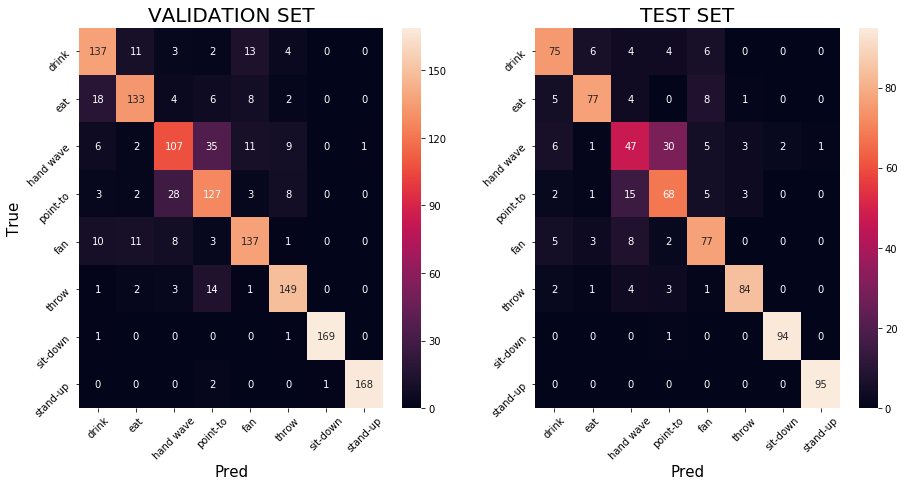

classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the next frame
Adapting the data to the next frame
Adapting the data to the next frame
number of zeros train (after padding):		27780690 - 66.81%
number of zeros validation (after padding):	6947731 - 66.83%
number of zeros test (after padding):		3879944 - 67.12%
Dataset train shape:		 (5460, 224, 17, 2)
Dataset validation shape:	 (1365, 224, 17, 2)
Dataset test shape:		 (759, 224, 17, 2)
PoseNet-101-relativeToNextFrame.h5
Val acc: 0.5787545787545788
Test acc: 0.546772068511199


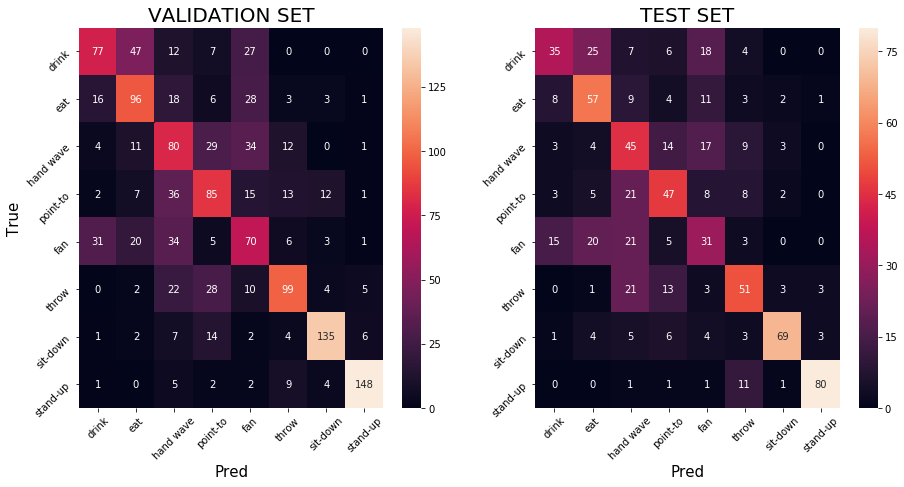

classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
normalising train, val and test values BEFORE padding
number of zeros train (after padding):		27738866 - 66.41%
number of zeros validation (after padding):	6942018 - 66.48%
number of zeros test (after padding):		3869268 - 66.64%
Dataset train shape:		 (5460, 225, 17, 2)
Dataset validation shape:	 (1365, 225, 17, 2)
Dataset test shape:		 (759, 225, 17, 2)
PoseNet-101-norm.h5
Val acc: 0.8556776556776556
Test acc: 0.847167325428195


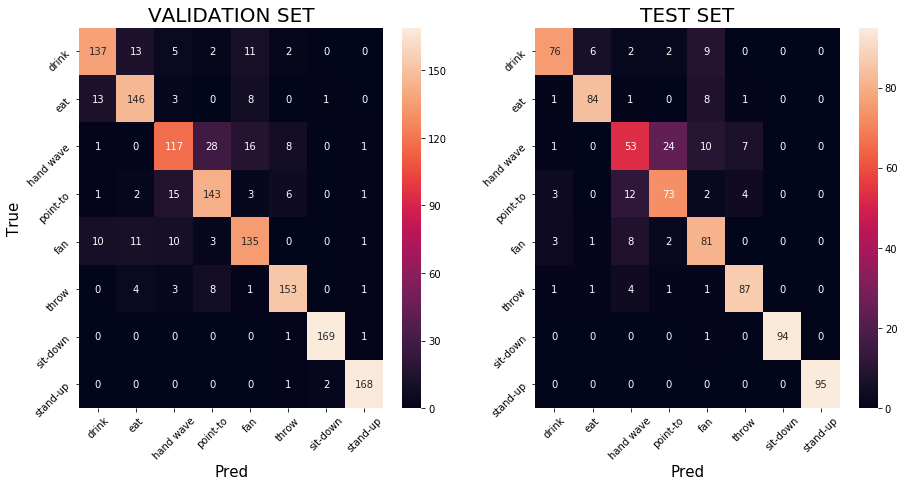

classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the next frame
Adapting the data to the next frame
Adapting the data to the next frame
normalising train, val and test values BEFORE padding
number of zeros train (after padding):		27738866 - 66.71%
number of zeros validation (after padding):	6942018 - 66.78%
number of zeros test (after padding):		3869268 - 66.94%
Dataset train shape:		 (5460, 224, 17, 2)
Dataset validation shape:	 (1365, 224, 17, 2)
Dataset test shape:		 (759, 224, 17, 2)
PoseNet-101-relativeToNextFrame-norm.h5
Val acc: 0.2879120879120879
Test acc: 0.2648221343873518


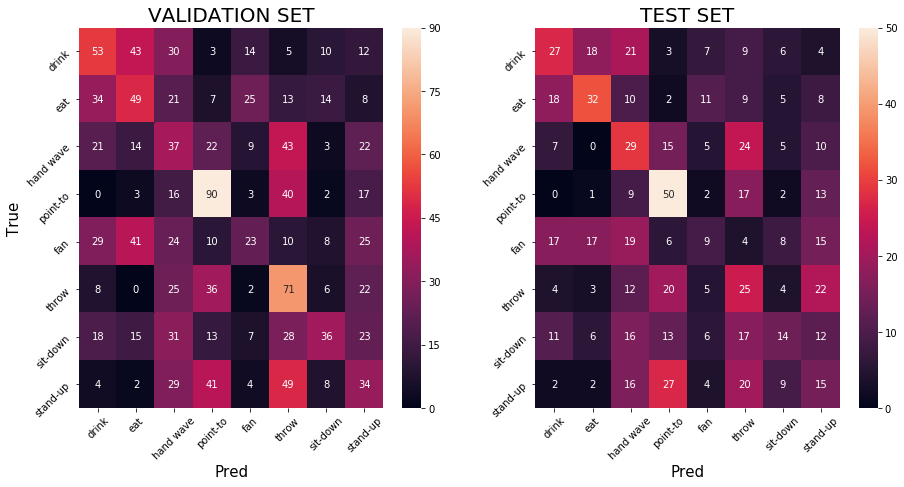

classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
number of zeros train (after padding):		27798672 - 66.55%
number of zeros validation (after padding):	6951708 - 66.57%
number of zeros test (after padding):		3883446 - 66.88%
Dataset train shape:		 (5460, 225, 17, 2)
Dataset validation shape:	 (1365, 225, 17, 2)
Dataset test shape:		 (759, 225, 17, 2)
PoseNet-101.h5
Val acc: 0.2835164835164835
Test acc: 0.24242424242424243


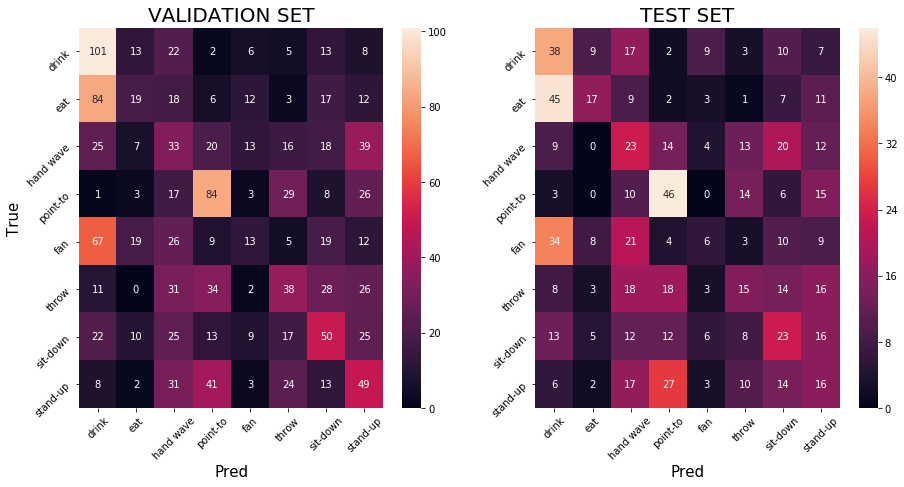

classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the center of each video
Adapting the data to the center of each video
Adapting the data to the center of each video
number of zeros train (after padding):		27784433 - 66.52%
number of zeros validation (after padding):	6932940 - 66.39%
number of zeros test (after padding):		3832786 - 66.01%
Dataset train shape:		 (5460, 225, 17, 2)
Dataset validation shape:	 (1365, 225, 17, 2)
Dataset test shape:		 (759, 225, 17, 2)
keypoint_rcnn_X_101_32x8d_FPN_3x-relativeToVideoCenter.h5
Val acc: 0.9076923076923077
Test acc: 0.8722002635046113


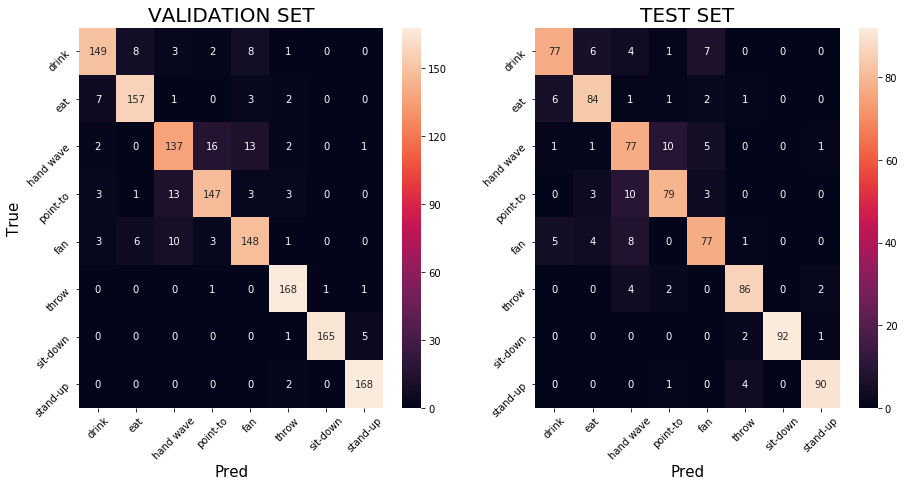

classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the center of each video
Adapting the data to the center of each video
Adapting the data to the center of each video
normalising train, val and test values BEFORE padding
number of zeros train (after padding):		27784426 - 66.52%
number of zeros validation (after padding):	6932940 - 66.39%
number of zeros test (after padding):		3832786 - 66.01%
Dataset train shape:		 (5460, 225, 17, 2)
Dataset validation shape:	 (1365, 225, 17, 2)
Dataset test shape:		 (759, 225, 17, 2)
keypoint_rcnn_X_101_32x8d_FPN_3x-relativeToVideoCenter-norm.h5
Val acc: 0.8923076923076924
Test acc: 0.8748353096179183


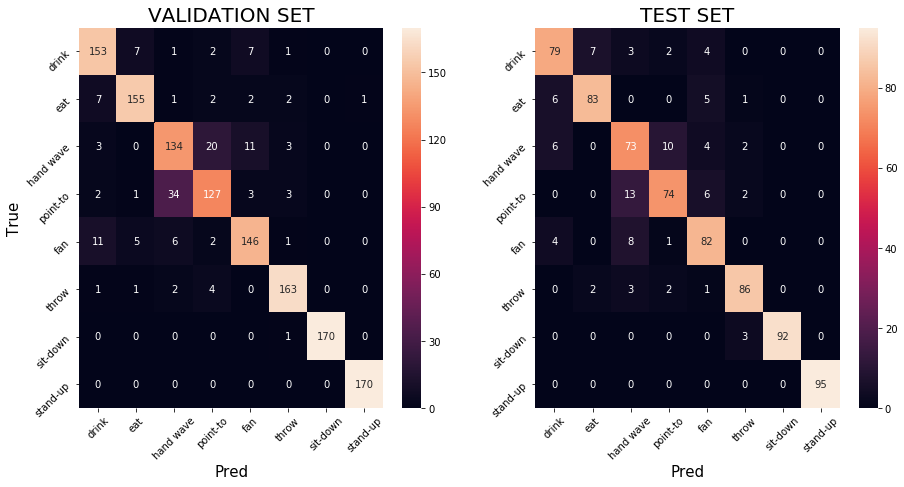

classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
normalising train, val and test values BEFORE padding
number of zeros train (after padding):		27784426 - 66.52%
number of zeros validation (after padding):	6932940 - 66.39%
number of zeros test (after padding):		3832786 - 66.01%
Dataset train shape:		 (5460, 225, 17, 2)
Dataset validation shape:	 (1365, 225, 17, 2)
Dataset test shape:		 (759, 225, 17, 2)
keypoint_rcnn_X_101_32x8d_FPN_3x-norm.h5
Val acc: 0.9010989010989011
Test acc: 0.8748353096179183


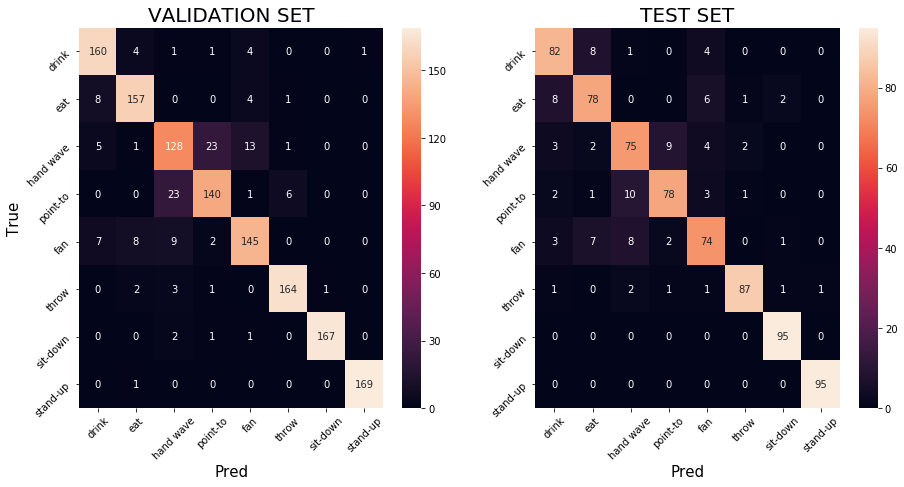

classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the next frame
Adapting the data to the next frame
Adapting the data to the next frame
normalising train, val and test values BEFORE padding
number of zeros train (after padding):		27784426 - 66.82%
number of zeros validation (after padding):	6932940 - 66.69%
number of zeros test (after padding):		3832786 - 66.30%
Dataset train shape:		 (5460, 224, 17, 2)
Dataset validation shape:	 (1365, 224, 17, 2)
Dataset test shape:		 (759, 224, 17, 2)
keypoint_rcnn_X_101_32x8d_FPN_3x-relativeToNextFrame-norm.h5
Val acc: 0.2761904761904762
Test acc: 0.2727272727272727


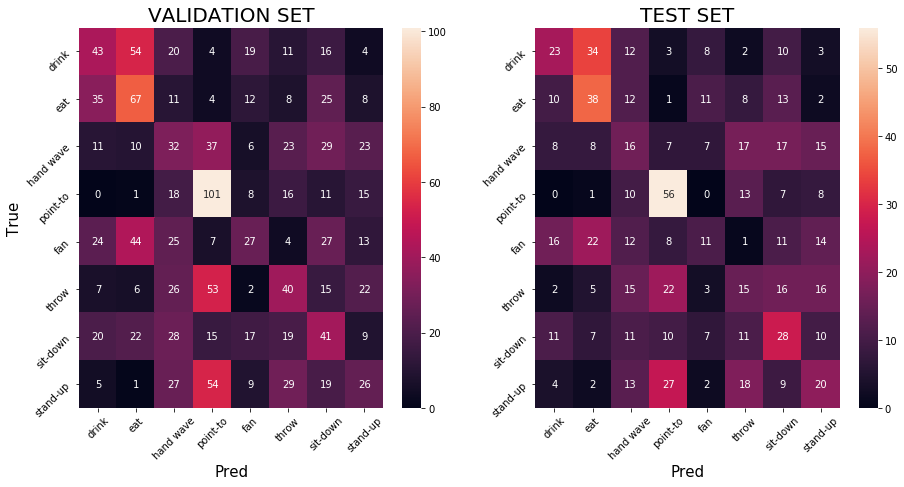

classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the next frame
Adapting the data to the next frame
Adapting the data to the next frame
number of zeros train (after padding):		27784916 - 66.82%
number of zeros validation (after padding):	6933054 - 66.69%
number of zeros test (after padding):		3832848 - 66.31%
Dataset train shape:		 (5460, 224, 17, 2)
Dataset validation shape:	 (1365, 224, 17, 2)
Dataset test shape:		 (759, 224, 17, 2)
keypoint_rcnn_X_101_32x8d_FPN_3x-relativeToNextFrame.h5
Val acc: 0.8827838827838828
Test acc: 0.8656126482213439


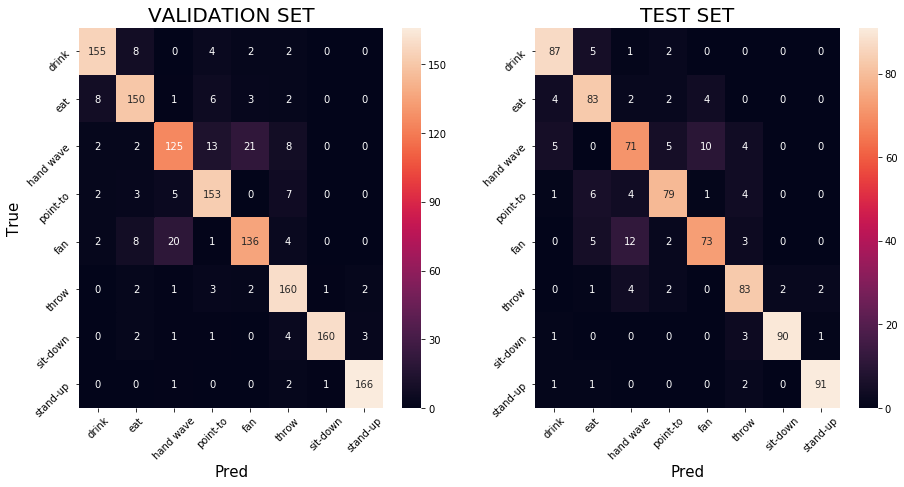

classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
number of zeros train (after padding):		27784426 - 66.52%
number of zeros validation (after padding):	6932940 - 66.39%
number of zeros test (after padding):		3832786 - 66.01%
Dataset train shape:		 (5460, 225, 17, 2)
Dataset validation shape:	 (1365, 225, 17, 2)
Dataset test shape:		 (759, 225, 17, 2)
keypoint_rcnn_X_101_32x8d_FPN_3x.h5
Val acc: 0.2695970695970696
Test acc: 0.2621870882740448


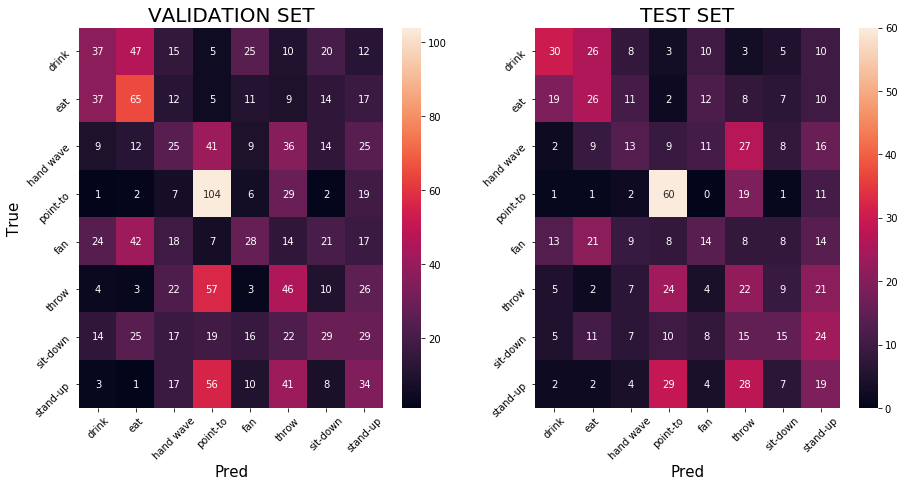

In [121]:
from os import scandir
from os.path import basename
from keras.models import load_model
savedModels = [f for f in scandir(SAVED_MODEL_FOLDER) if f.path[-3:] == ".h5"]
model_names = ["PoseNet-101","keypoint_rcnn_X_101_32x8d_FPN_3x"]
for model_to_analyse in model_names:
    datasetName = DATASET_FOLDER+model_to_analyse+"-SPLIT-dataset.pickle"
    with open(datasetName,'rb') as file_in:
        train_set, val_set, test_set = pickle.load(file_in)
    for saved_model in savedModels:
        modelName, preprocess_functions, normalise = fromFileNameToParameters(saved_model)
        if modelName != model_to_analyse:
            continue
        X_train, y_train, X_val, y_val, X_test, y_test = preprocessData(train_set, val_set, test_set, normalise, preprocess_functions)
        loadedModel = load_model(SAVED_MODEL_FOLDER+saved_model.name)
        print(basename(saved_model))
        plotValTestResult(loadedModel, X_val, y_val, X_test, y_test)

In [128]:
from os import scandir
from os.path import basename
from keras.models import load_model
savedModels = [f for f in scandir(SAVED_MODEL_FOLDER) if f.path[-3:] == ".h5"]
model_names = ["PoseNet-101","keypoint_rcnn_X_101_32x8d_FPN_3x"]
results = []
for model_to_analyse in model_names:
    datasetName = DATASET_FOLDER+model_to_analyse+"-SPLIT-dataset.pickle"
    with open(datasetName,'rb') as file_in:
        train_set, val_set, test_set = pickle.load(file_in)
    for saved_model in savedModels:
        modelName, preprocess_functions, normalise = fromFileNameToParameters(saved_model)
        if modelName != model_to_analyse:
            continue
        X_train, y_train, X_val, y_val, X_test, y_test = preprocessData(train_set, val_set, test_set, normalise, preprocess_functions)
        loadedModel = load_model(SAVED_MODEL_FOLDER+saved_model.name)
        print(basename(saved_model))
        val_acc, test_acc = getValTestAccuracy(loadedModel, X_val, y_val, X_test, y_test)
        print("Validation accuracy:",val_acc,"\nTest accuracy:",test_acc)
        results.append((basename(saved_model),val_acc, test_acc))
#         plotValTestResult(loadedModel, X_val, y_val, X_test, y_test)
print("DONE!")

classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the center of each video
Adapting the data to the center of each video
Adapting the data to the center of each video
number of zeros train (after padding):		27738866 - 66.41%
number of zeros validation (after padding):	6942018 - 66.48%
number of zeros test (after padding):		3869268 - 66.64%
Dataset train shape:		 (5460, 225, 17, 2)
Dataset validation shape:	 (1365, 225, 17, 2)
Dataset test shape:		 (759, 225, 17, 2)
PoseNet-101-relativeToVideoCenter.h5
Validation accuracy: 0.8688644688644689 
Test accuracy: 0.8511198945981555
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the center of each video
Adapting the data to the center of each video
Adapting the data to the center of each vid

In [114]:
loadedModel = load_model(SAVED_MODEL_FOLDER+saved_model.name)

## continue training

In [13]:
# modelName = 'simple-model.h5'

In [14]:
# from keras.models import load_model
# model = load_model(modelName)

#Continue training
# model.fit(second_training, second_classes, batch_size=32, nb_epoch=20)

# history = model.fit(X_train, y_train,
#                     epochs=EPOCHS,
#                     batch_size=BATCH_SIZE,
# #                     validation_split=0.2
#                     validation_data=(X_val, y_val)
#                    )

Train on 5460 samples, validate on 1365 samples
Epoch 1/10
5460/5460 [==============================] - 35s 6ms/step - loss: 1.2101 - accuracy: 0.4623 - val_loss: 1.2212 - val_accuracy: 0.4718
Epoch 2/10
 368/5460 [=>............................] - ETA: 29s - loss: 1.1121 - accuracy: 0.4810

KeyboardInterrupt: 

# Display classification

In [43]:
from sklearn.metrics import confusion_matrix, accuracy_score

label_order = [1, 2, 31, 38, 49, 7, 8, 9]
y_pred = loadedModel.predict_classes(X_val)
# label_order = ["1", "2", "31", "38", "49", "7", "8", "9"]
y_pred_labels = [label_order[i] for i in y_pred]
y_val_labels = [label_order[np.argmax(i)] for i in y_val]

In [45]:
accuracy_score(y_pred=y_pred_labels,y_true=y_val_labels)

0.8827838827838828

In [46]:
yTrue=y_pred_labels
yPred=y_test_labels
conf_mat = confusion_matrix(y_true=yTrue, y_pred=yPred, labels=label_order)
conf_mat

array([[133,  16,   4,   4,   8,   0,   0,   0],
       [ 10, 110,   4,   1,  12,   2,   0,   0],
       [  3,   5, 130,   8,   3,   4,   0,   0],
       [  6,   1,   2, 108,   6,   1,   1,   0],
       [  3,   4,   2,   1, 113,   1,   0,   0],
       [  0,   0,   3,   2,   0, 119,   0,   1],
       [  0,   0,   1,   0,   1,   2, 130,   0],
       [  0,   0,   1,   0,   0,   1,   4, 121]])

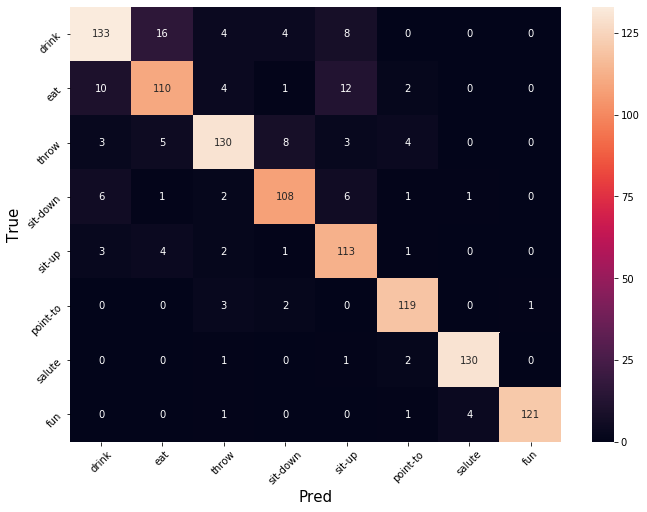

In [41]:
import seaborn as sn
plt.figure(figsize = (11,8))
ax = plt.axes()
labelString = ["drink", "eat", "throw", "sit-down", "sit-up", "point-to", "salute", "fun"]
ax = sn.heatmap(conf_mat, annot=True,xticklabels=labelString,yticklabels=labelString, fmt='g')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# plt.title('', fontsize = 20) # title with fontsize 20
plt.xlabel('Pred', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True', fontsize = 15) # y-axis label with fontsize 15

plt.show()

# ACTION_LABEL_SET = 
# A001  - A002 - A007 - A008     - A009   - A031               - A038   -  A049
# drink - eat - throw - sit down - sit up - point to something - salute - make a fun 


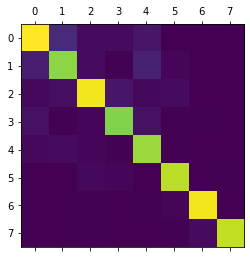

In [42]:
plt.matshow(conf_mat)